In [6]:
import mrcfile
import yaml
import numpy as np
import matplotlib.pyplot as plt


In [13]:
def _relativistic_lambda(voltage):
    # returns the relativistic wavelength in Angstrom
    # voltage should be in volts
    return 12.2643247 / np.sqrt(voltage * (1 + voltage * 0.978466e-6))


def simulate_ctf(defocus, amp, Cs, B, voltage, k):
    wavelength = _relativistic_lambda(voltage)
    gamma = (-np.pi / 2) * Cs * np.power(wavelength, 3) * np.power(
        k, 4
    ) + np.pi * wavelength * defocus * np.power(k, 2)
    CTF = -1 * np.sin(amp + gamma)
    if B != 0:
        CTF *= np.exp(-B * k**2)

    return CTF


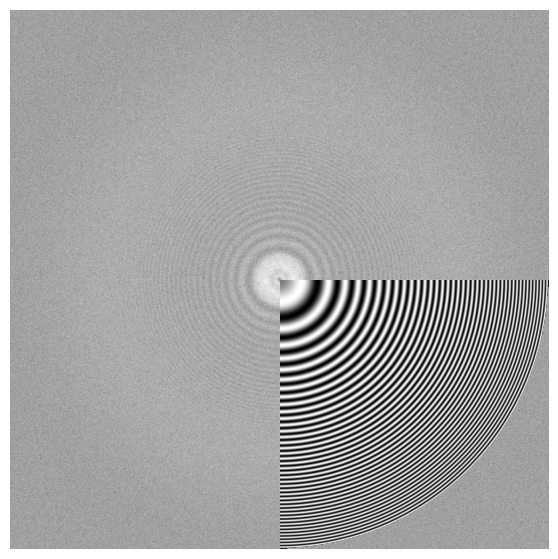

In [24]:
mrc_file = "/home/mjoosten1/projects/roodmus/testing_data/plot_ctf/mrc_dir/000000.mrc"
config_file = "/home/mjoosten1/projects/roodmus/testing_data/plot_ctf/config_dir/000000.yaml"

config = yaml.load(open(config_file), Loader=yaml.FullLoader)
defocus = config["microscope"]["lens"]["c_10"] # defocus in Angstrom
C_s = config["microscope"]["lens"]["c_30"] # Spherical aberration in mm
C_s *= 1e7 # convert to Angstrom
amp = 0.05
B = 0
apix = 1
V = 300e3 # voltage in volts

im = mrcfile.open(mrc_file).data.squeeze()
im_fft = np.fft.fftshift(np.fft.fft2(im))


fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(np.log(np.abs(im_fft)), cmap="gray", vmin=np.quantile(np.log(np.abs(im_fft)), 0.01), vmax=np.quantile(np.log(np.abs(im_fft)), 0.99))
ax.axis("off")

fx = np.fft.fftshift(np.fft.fftfreq(im_fft.shape[0], apix))
fy = np.fft.fftshift(np.fft.fftfreq(im_fft.shape[1], apix))
freq = np.sqrt(np.add.outer(fx**2, fy**2))
ctf = simulate_ctf(
    defocus=defocus, amp=amp, Cs=C_s, B=B, voltage=V, k=freq
)

# mask out the first quadrant of the CTF
ctf[:ctf.shape[0]//2, :ctf.shape[1]//2] = 0
ctf[ctf.shape[0]//2:, :ctf.shape[1]//2] = 0
ctf[:ctf.shape[0]//2, ctf.shape[1]//2:] = 0

# apply a circular mask
circle = freq < 0.5 * 1 / apix
ctf *= circle
ctf[ctf==0] = np.nan

ax.imshow(ctf, cmap="gray")



(512, 512)


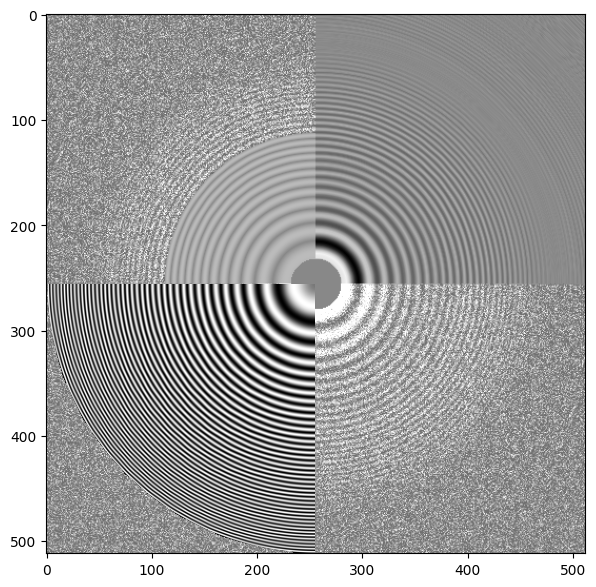

In [32]:
ctffind_mrc_file = "/home/mjoosten1/projects/roodmus/testing_data/plot_ctf/mrc_dir/diagnostic_output.mrc"
ctffind_mrc = mrcfile.open(ctffind_mrc_file).data.squeeze()

print(ctffind_mrc.shape)

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(ctffind_mrc, cmap="gray")

defocus = -15291.579102
C_s = 2.7 # Spherical aberration in mm
C_s *= 1e7 # convert to Angstrom
amp = 0.07
B = 0
apix = 1
V = 300e3 # voltage in volts

fx = np.fft.fftshift(np.fft.fftfreq(ctffind_mrc.shape[0], apix))
fy = np.fft.fftshift(np.fft.fftfreq(ctffind_mrc.shape[1], apix))
freq = np.sqrt(np.add.outer(fx**2, fy**2))
ctf = simulate_ctf(
    defocus=defocus, amp=amp, Cs=C_s, B=B, voltage=V, k=freq
)

# mask out the first quadrant of the CTF
ctf[:ctf.shape[0]//2, :ctf.shape[1]//2] = 0
# ctf[ctf.shape[0]//2:, :ctf.shape[1]//2] = 0
ctf[:ctf.shape[0]//2, ctf.shape[1]//2:] = 0
ctf[ctf.shape[0]//2:, ctf.shape[1]//2:] = 0

# apply a circular mask
circle = freq < 0.5 * 1 / apix
ctf *= circle
ctf[ctf==0] = np.nan

ax.imshow(ctf, cmap="gray")